In [ ]:
# 第10章 注意力机制

## 10.1 注意力提示

### 练习10.1.1

在机器翻译中通过解码序列词元时，其自主性提示可能是什么？非自主性提示和感官输入又是什么？

**解答：**
query是自主性提示，key是非自主性提示，感官输入是value。

### 练习10.1.2

随机生成一个$10 \times 10$矩阵并使用`softmax`运算来确保每行都是有效的概率分布，然后可视化输出注意力权重。

**解答：**

In [4]:
import torch
from d2l import torch as d2l

def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5,2.5), cmap='Reds'):
    #d2l.use_svg_display()
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize,
                               sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes,matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes,row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6)

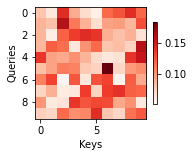

In [5]:
attention_weights = torch.nn.Softmax(dim=1)(torch.rand(10,10)).reshape((1,1,10,10))
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

## 10.2 注意力汇聚：Nadaraya-Watson核回归

### 练习10.2.1

增加训练数据的样本数量，能否得到更好的非参数的Nadaraya-Watson核回归模型？

**解答：**

    使用数据量500及1000进行实验，代码及对应结果如下：

In [13]:
import torch.nn as nn
class NWKernelRegression(nn.Module): 
    def __init__(self, **kwargs): 
        super().__init__(**kwargs) 
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True)) 
    def forward(self, queries, keys, values): 
        # queries和attention_weights的形状为(查询个数, “键-值”对个数) 
        queries = queries.repeat_interleave(
            keys.shape[1]).reshape((-1, keys.shape[1])) 
        self.attention_weights = nn.functional.softmax( 
            -((queries - keys) * self.w)**2 / 2, dim=1) # values的形状为(查询个数, “键-值”对个数) 
        return torch.bmm(self.attention_weights.unsqueeze(1), 
                         values.unsqueeze(-1)).reshape(-1)

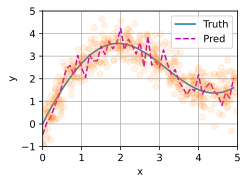

In [14]:
# 数据量 500

# 生成数据集
n_train = 500
x_train, _ = torch.sort(torch.rand(n_train)*5)
def f(x):     
    return 2*torch.sin(x)+x**0.8
y_train = f(x_train) + torch.normal(0,0.5,(n_train,))
x_test = torch.arange(0,5,0.1)
y_truth = f(x_test)
n_test = len(x_test)

# X_tile的形状:(n_train,n_train),每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1)) 
# Y_tile的形状:(n_train,n_train),每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1)) 
# keys的形状:('n_train','n_train'-1) 
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1)) 
# values的形状:('n_train','n_train'-1) 
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(),lr=0.5)
animator = d2l.Animator(xlabel='epoch',ylabel='loss',xlim=[1,5])
for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train,keys,values),y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch{epoch+1},loss{float(l.sum()):.6f}')
    animator.add(epoch+1,float(l.sum()))
    
    
#keys的形状:(n_test,n_train),每一行包含着相同的训练输入(例如,相同的键)
keys = x_train.repeat((n_test, 1)) 
# value的形状:(n_test,n_train) 
values = y_train.repeat((n_test, 1)) 
y_hat = net(x_test, keys, values).unsqueeze(1).detach() 
plot_kernel_reg(y_hat)

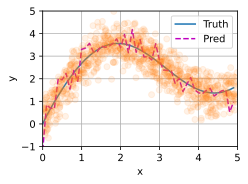

In [12]:
# 数据量1000
# 生成数据集
n_train = 1000
x_train, _ = torch.sort(torch.rand(n_train)*5)
def f(x):     
    return 2*torch.sin(x)+x**0.8
y_train = f(x_train) + torch.normal(0,0.5,(n_train,))
x_test = torch.arange(0,5,0.1)
y_truth = f(x_test)
n_test = len(x_test)

# X_tile的形状:(n_train,n_train),每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1)) 
# Y_tile的形状:(n_train,n_train),每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1)) 
# keys的形状:('n_train','n_train'-1) 
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1)) 
# values的形状:('n_train','n_train'-1) 
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(),lr=0.5)
animator = d2l.Animator(xlabel='epoch',ylabel='loss',xlim=[1,5])
for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train,keys,values),y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch{epoch+1},loss{float(l.sum()):.6f}')
    animator.add(epoch+1,float(l.sum()))
    
    
#keys的形状:(n_test,n_train),每一行包含着相同的训练输入(例如,相同的键)
keys = x_train.repeat((n_test, 1)) 
# value的形状:(n_test,n_train) 
values = y_train.repeat((n_test, 1)) 
y_hat = net(x_test, keys, values).unsqueeze(1).detach() 
plot_kernel_reg(y_hat)

    综上可以发现，增加训练数据的样本数量不能得到更好的非参数的Nadaraya-Watson核回归模型。

### 练习10.2.2

在带参数的注意力汇聚的实验中学习得到的参数$w$的价值是什么？为什么在可视化注意力权重时，它会使加权区域更不平滑？

**解答：**

    首先将参数w输出来看一下：

In [30]:
net.w

Parameter containing:
tensor([162.2310], requires_grad=True)

值大约为162，且参数w​只是一个attention_weights = nn.functional.softmax(-((x_repeat - x_train) * 7.5)**2 / 2, dim=1)标量参数，不是向量，那就说明w都是相同的参数162，我们试着将非参数注意力汇聚添加一个162的权重：

In [24]:
attention_weights = nn.functional.softmax(-((X_repeat - x_train) * 162)**2 / 2, dim=1)

可以得到类似参数注意力汇聚一样的效果。

可以发现这样的话拟合效果就更好了，但是也变成了和参数注意力汇聚一样尖锐的加权区域。那么为什么在可视化注意力权重时，它会使加权区域更加尖锐？

我们观察上述公式发现，w在(x-x_i)之外，平方之内，乘以一个-1/2之后就相当于绝对值扩大了13122倍左右，我们知道softmax函数在x趋向负无穷的时候值无限趋近于0，所以这样一来就保留了键和查询之间的差距足够小的pair，过滤掉了键和值差距较大的pair，从而达到注意力效果，使得预测结果更加准确。



### 练习10.2.3

如何将超参数添加到非参数的Nadaraya-Watson核回归中以实现更好地预测结果？

**解答：**

In [ ]:
attention_weights = nn.functional.softmax(-((x_repeat - x_train) * hyperpara)**2 / 2, dim=1)

如上述添加一个固定的权重hyperpara即可得到更好的拟合效果。

### 练习10.2.4

为本节的核回归设计一个新的带参数的注意力汇聚模型。训练这个新模型并可视化其注意力权重。

**解答：**

## 10.3 注意力评分函数

### 练习10.3.1

修改小例子中的键，并且可视化注意力权重。加性注意力和缩放点积注意力是否仍然产生相同的结果？为什么？

**解答：**

In [10]:
import math 
import torch 
from torch import nn 
from d2l import torch as d2l

In [11]:
def masked_softmax(X, valid_lens): 
    """通过在最后一个轴上掩蔽元素来执行softmax操作""" 
    # X:3D张量,valid_lens:1D或2D张量
    if valid_lens is None: 
        return nn.functional.softmax(X, dim=-1) 
    else: 
        shape = X.shape 
        if valid_lens.dim() == 1: 
            valid_lens = torch.repeat_interleave(
                valid_lens, shape[1]) 
        else: 
            valid_lens = valid_lens.reshape(-1) 
            # 最后一轴上被掩蔽的元素使用一个非常大的负值替换,
            #从而其softmax输出为0 
        X = d2l.sequence_mask(
            X.reshape(-1, shape[-1]), valid_lens, value=-1e6) 
        return nn.functional.softmax(
            X.reshape(shape), dim=-1)

In [12]:
class DotProductAttention(nn.Module): 
    """缩放点积注意力""" 
    def __init__(self, dropout, **kwargs): 
        super(DotProductAttention, self).__init__(**kwargs) 
        self.dropout = nn.Dropout(dropout) 
        # queries的形状:(batch_size,查询的个数,d) 
        # keys的形状:(batch_size, “键-值”对的个数,d) 
        # values的形状:(batch_size, “键-值”对的个数,值的维度) 
        # valid_lens的形状:(batch_size,)或者(batch_size,查询的个数) 
    def forward(self, queries, keys, values, valid_lens=None): 
        d = queries.shape[-1] 
        # 设置transpose_b=True为了交换keys的最后两个维度
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d) 
        self.attention_weights = masked_softmax(scores, valid_lens) 
        return torch.bmm(self.dropout(self.attention_weights), values)

In [13]:
class AdditiveAttention(nn.Module): 
    """加性注意力""" 
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs): 
        super(AdditiveAttention, self).__init__(**kwargs) 
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False) 
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False) 
        self.w_v = nn.Linear(num_hiddens, 1, bias=False) 
        self.dropout = nn.Dropout(dropout) 
    def forward(self, queries, keys, values, valid_lens): 
        queries, keys = self.W_q(queries), self.W_k(keys) 
        # 在维度扩展后, 
        # queries的形状:(batch_size,查询的个数,1,num_hidden) 
        # key的形状:(batch_size,1, “键-值”对的个数,num_hiddens) 
        # 使用广播方式进行求和
        features = queries.unsqueeze(2) + keys.unsqueeze(1) 
        features = torch.tanh(features) 
        # self.w_v仅有一个输出,因此从形状中移除最后那个维度。
        # scores的形状:(batch_size,查询的个数, “键-值”对的个数) 
        scores = self.w_v(features).squeeze(-1) 
        self.attention_weights = masked_softmax(scores, valid_lens) 
        # values的形状:(batch_size, “键-值”对的个数,值的维度) 
        return torch.bmm(self.dropout(self.attention_weights), values)

In [14]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.normal(0,1,(2, 10, 2)) 
# values的小批量,两个值矩阵是相同的
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat( 2, 1, 1) 
valid_lens = torch.tensor([2, 6]) 
attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8, dropout=0.1) 
attention.eval() 
attention(queries, keys, values, valid_lens)

tensor([[[ 1.9820,  2.9820,  3.9820,  4.9820]],

        [[ 9.8150, 10.8150, 11.8150, 12.8150]]], grad_fn=<BmmBackward0>)

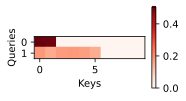

In [15]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)), xlabel='Keys', ylabel='Queries')

In [16]:
queries = torch.normal(0, 1, (2, 1, 2)) 
attention = DotProductAttention(dropout=0.5) 
attention.eval() 
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0259,  3.0259,  4.0259,  5.0259]],

        [[ 9.9798, 10.9798, 11.9798, 12.9798]]])

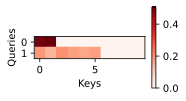

In [17]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)), xlabel='Keys', ylabel='Queries')

将可加性注意力和缩放的“点-积”注意力不能产生相同的结果，“点-积”注意力产生的注意力群众更集中于某一个元素，而加性注意力的权重更加均匀。 

### 练习10.3.2

只使用矩阵乘法，能否为具有不同矢量长度的查询和键设计新的评分函数？

**解答：**
- 使用一个矩阵W{dq,dk}和Q相乘，将Q转换成和K相同的维度
- 将Q和K使用pad填充的方式转换成相同长度

### 练习10.3.3

当查询和键具有相同的矢量长度时，矢量求和作为评分函数是否比点积更好？为什么？

**解答：**

点积可能比矢量求和更好。
例子：
query向量是[w1,w2]，key向量是[a,b] 。
如果我们使用点积，输出是aw1+bw2，空间是一个平面。
但如果我们使用求和法，输出是[a+w1,b+w2]，空间是一个平面的点。

所以使用点积比求和法有更大的解空间，它比求和法更适合数据集。

如果我们比较一下这两个公式，就会发现，加法注意力包含了3个可学习的参数： Wq、Wk和Wv，而缩放点积注意力没有引入任何可学习的参数。
我猜想，如果我们真的训练出加法注意力的模型，这3个可学习的参数会使模型表现得像缩放点积注意力。换句话说，Wq、Wk会帮助查询将自己投射到关键的地方。


## 10.4 Bahdanau 注意力

### 练习10.4.1

在实验中用LSTM替换GRU。

**解答：**

In [5]:
import torch
from d2l import torch as d2l
from torch import nn


class AttentionDecoder(d2l.Decoder): 
    """带有注意力机制解码器的基本接口""" 
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)
    @property
    def attention_weights(self):
        raise NotImplementedError


In [6]:
# 用LSTM替换GRU，包含三处修改
class Seq2SeqLSTMAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqLSTMAttentionDecoder, self).__init__(**kwargs)
        self.attention = d2l.AdditiveAttention(
            num_hiddens, num_hiddens, num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(
            embed_size+ num_hiddens , num_hiddens, num_layers,
            dropout=dropout)#修改1
        self.dense = nn.Linear(num_hiddens, vocab_size)
    def init_state(self, enc_outputs, enc_valid_lens, *args):
        # outputs的形状为(batch_size，num_steps，num_hiddens).
        # hidden_state的形状为(num_layers，batch_size，num_hiddens) 
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), (hidden_state,hidden_state), enc_valid_lens)#修改2
    def forward(self, X, state):
        # enc_outputs的形状为(batch_size,num_steps,num_hiddens). # hidden_state的形状为(num_layers,batch_size,
        # num_hiddens)
        enc_outputs, hidden_state, enc_valid_lens = state
        # 输出X的形状为(num_steps,batch_size,embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # query的形状为(batch_size,1,num_hiddens)
            #query = torch.unsqueeze(hidden_state[-1], dim=1)
            query=torch.unsqueeze(hidden_state[0][-1], dim=1)#修改3
            # context的形状为(batch_size,1,num_hiddens) 
            context = self.attention(
                query, enc_outputs, enc_outputs, enc_valid_lens)
            # 在特征维度上连结
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # 将x变形为(1,batch_size,embed_size+num_hiddens)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state) 
            outputs.append(out) 
            self._attention_weights.append(self.attention.attention_weights)
        # 全连接层变换后，outputs的形状为
        # (num_steps,batch_size,vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,enc_valid_lens]

    
    @property
    def attention_weights(self):
        return self._attention_weights

In [7]:
encoder = d2l.Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                                                           num_layers=2)
decoder = Seq2SeqLSTMAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                                  num_layers=2)
decoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)  # (batch_size,num_steps)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
output.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape




(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), 2, torch.Size([2, 4, 16]))

loss 0.021, 13598.3 tokens/sec on cpu
CPU times: user 42.3 s, sys: 13 s, total: 55.3 s
Wall time: 40.5 s


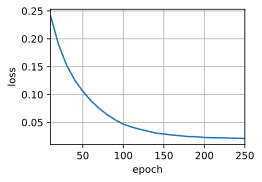

In [8]:
%%time
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, d2l.try_gpu()
train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = d2l.Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqLSTMAttentionDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

### 练习10.4.2

修改实验以将加性注意力评分函数替换为缩放点积注意力，它如何影响训练效率？

**解答：**

In [18]:
class Seq2SeqDotProductAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqDotProductAttentionDecoder, self).__init__(**kwargs)
        self.attention = d2l.DotProductAttention(dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size + num_hiddens, num_hiddens, num_layers,
            dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)
    def init_state(self, enc_outputs, enc_valid_lens, *args):
        # outputs的形状为(batch_size，num_steps，num_hiddens).
        # hidden_state的形状为(num_layers，batch_size，num_hiddens) 
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)
    def forward(self, X, state):
        # enc_outputs的形状为(batch_size,num_steps,num_hiddens). # hidden_state的形状为(num_layers,batch_size,
        # num_hiddens)
        enc_outputs, hidden_state, enc_valid_lens = state
        # 输出X的形状为(num_steps,batch_size,embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # query的形状为(batch_size,1,num_hiddens)
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # context的形状为(batch_size,1,num_hiddens) 
            context = self.attention(
                query, enc_outputs, enc_outputs, enc_valid_lens)
            # 在特征维度上连结
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # 将x变形为(1,batch_size,embed_size+num_hiddens)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state) 
            outputs.append(out) 
            self._attention_weights.append(self.attention.attention_weights)
        # 全连接层变换后，outputs的形状为
        # (num_steps,batch_size,vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,enc_valid_lens]

    
    @property
    def attention_weights(self):
        return self._attention_weights

In [19]:
class Seq2SeqDotProductAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqDotProductAttentionDecoder, self).__init__(**kwargs)
        self.attention = d2l.DotProductAttention(dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size + num_hiddens, num_hiddens, num_layers,
            dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)
    def init_state(self, enc_outputs, enc_valid_lens, *args):
        # outputs的形状为(batch_size，num_steps，num_hiddens).
        # hidden_state的形状为(num_layers，batch_size，num_hiddens) 
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)
    def forward(self, X, state):
        # enc_outputs的形状为(batch_size,num_steps,num_hiddens). # hidden_state的形状为(num_layers,batch_size,
        # num_hiddens)
        enc_outputs, hidden_state, enc_valid_lens = state
        # 输出X的形状为(num_steps,batch_size,embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # query的形状为(batch_size,1,num_hiddens)
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # context的形状为(batch_size,1,num_hiddens) 
            context = self.attention(
                query, enc_outputs, enc_outputs, enc_valid_lens)
            # 在特征维度上连结
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # 将x变形为(1,batch_size,embed_size+num_hiddens)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state) 
            outputs.append(out) 
            self._attention_weights.append(self.attention.attention_weights)
        # 全连接层变换后，outputs的形状为
        # (num_steps,batch_size,vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,enc_valid_lens]

    
    @property
    def attention_weights(self):
        return self._attention_weights

In [20]:
encoder = d2l.Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                                                           num_layers=2)
decoder = Seq2SeqDotProductAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                                  num_layers=2)
decoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)  # (batch_size,num_steps)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
output.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape





(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), 2, torch.Size([4, 16]))

loss 0.021, 16727.9 tokens/sec on cpu
CPU times: user 36.2 s, sys: 8.69 s, total: 44.9 s
Wall time: 34.3 s


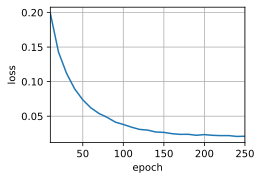

In [21]:
%%time
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, d2l.try_gpu()
train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = d2l.Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDotProductAttentionDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

## 10.5 多头注意力

### 练习10.5.1

分别可视化这个实验中的多个头的注意力权重。

**解答：**

### 练习10.5.2

假设有一个完成训练的基于多头注意力的模型，现在希望修剪最不重要的注意力头以提高预测速度。如何设计实验来度量注意力头的重要性呢？

**解答：**

&emsp;&emsp;要度量注意力头的重要性，可以使用以下方法：

1. 可以使用类似于Dropout的技术，随机地将某些注意力头从模型中删除，然后比较删除前后模型的性能差异。
   1. 优点：简单易行
   2. 缺点：可能会导致模型过拟合
2. 可以使用Taylor Expansion来计算每个注意力头对于模型输出的贡献度。
   1. 优点：可以更准确地度量每个注意力头的重要性
   2. 缺点：计算量大
3. 可以使用Attention Flow来计算每个注意力头对于每个输入位置的重要性。
   1. 优点：可以更好地理解模型在处理输入序列时的行为。
   2. 缺点：计算量大，需要更多的内存来存储注意力权重。


## 10.6 自注意力和位置编码

### 练习10.6.1

假设设计一个深度架构，通过堆叠基于位置编码的自注意力层来表示序列。可能会存在什么问题？

**解答：**

&emsp;&emsp;如果仅仅是堆叠基于位置编码的自注意力层来表示序列，可能会存在一些问题。
1. 如果序列过长，那么每个位置都需要一个向量来表示，这会导致模型的参数数量过多，训练和推理的时间成本都会增加。
2. 如果序列中存在一些长距离的依赖关系，那么这些依赖关系可能会被忽略或者不够准确地建模。
3. 输入中含有位置编码信息，因此输出层也希望有位置编码信息。但是经过堆叠多层，下一层可能会丢失此（相对）位置信息。


### 练习10.6.2

请设计一种可学习的位置编码方法。

**解答：**

&emsp;&emsp;位置编码是一种用于Transformer等模型中的技术，用于为序列中的每个位置分配一个向量。最常见的位置编码方法是将位置的表示加到token的表示上，而每个位置的表示则为一个可学习的向量。这种编码方式最早是由ConvS2S提出，被BERT、GPT2、ERNIE、ALBERT、electra等模型所采用。

&emsp;&emsp;除了可学习的位置编码，还有一些其他的位置编码方法，例如Sinusoidal Position Encoding、Learned Positional Embedding和Complex Embedding等。这些方法各有优缺点，具体使用取决于具体情况。

&emsp;&emsp;设计一种可学习的位置编码方法，可以考虑将位置编码当作可训练参数，随机初始化一个矩阵作为位置编码，并随训练过程更新。例如BERT用的可学习位置编码，将位置信息P随机初始化，然后包装成一个可学习的参数。

[六种位置编码的代码实现及性能实验](https://zhuanlan.zhihu.com/p/415020704)


## 10.7 Transformer

### 练习10.7.1

在实验中训练更深的Transformer将如何影响训练速度和翻译效果？

**解答：**

&emsp;&emsp;在实验中[DeepNet: Scaling Transformers to 1,000 Layers](https://arxiv.org/abs/2203.00555)，将Transformer的深度扩展到1000层，可以提高模型的训练稳定性，并将模型深度进行数量级的扩展。

&emsp;&emsp;在另一项实验中[Very Deep Transformers for Neural Machine Translation](https://arxiv.org/abs/2008.07772)，研究者将标准的Transformer加深到60层encoder和12层decoder，发现如果不使用Admin初始化方法，模型不再收敛；使用Admin方法后，模型收敛并且BIEU相比标准的Transformer模型提升了2.5。

&emsp;&emsp;因此，增加Transformer的深度可能会影响训练速度和翻译效果。具体影响取决于具体情况，例如模型的初始化方法、数据集大小、训练时间等等。因此，在实际应用中需要权衡计算成本和模型性能。

### 练习10.7.2

在Transformer中使用加性注意力取代缩放点积注意力是不是个好办法？为什么？

**解答：**

&emsp;&emsp;Transformer模型提出了两种注意力机制：加型注意力机制 (additive attention)和点积型注意力机制 (dot-product attention)。其中加型注意力机制应用于之前的编解码结构，点积型注意力机制应用于自注意力结构。

&emsp;&emsp;加性注意力机制是一种形式的注意力机制，它可以在线性复杂度的序列中有效地总结重要信息。在加性注意力中，查询向量和键向量被映射到相同的维度，然后相加并通过一个非线性激活函数进行处理。加性注意力机制的优点是**可以处理更长的序列，但缺点是计算成本较高**。

&emsp;&emsp;因此，使用加性注意力取代缩放点积注意力是否好的问题取决于具体情况。如果需要处理更长的序列，则可以考虑使用加性注意力，但需要权衡计算成本和模型性能。

### 练习10.7.3

对于语言模型，应该使用Transformer的编码器还是解码器，或者两者都用？如何设计？

**解答：**

&emsp;&emsp;Transformer模型通常使用编码器，因为编码器可以将输入序列映射到一个语义空间中，从而提取输入序列的语义信息。在自然语言处理任务中，通常使用预训练的Transformer编码器来构建语言模型，例如BERT、GPT等。这些模型在预训练阶段使用大规模的文本数据进行训练，然后在下游任务中进行微调。

&emsp;&emsp;BERT和GPT都是基于Transformer架构的预训练语言模型。

- BERT是一个强大的预先训练的**编码器**模型，它基本上是Transformer架构的编码器堆栈，具有12层或24层编码器。在BERT中，输入序列首先被嵌入到向量空间中，然后被输入到Transformer编码器中。
- Bert——Masking Input。在Bert的预训练任务中，Bert主要使用“填空题"的方式来完成预训练：随机盖住一些输入的文字，被mask的部分是随机决定的，当我们输入一个句子时，其中的一些词会被随机mask。

- GPT则是使用Transformer **解码器**模块构建的，一次只输出一个单词（token）。在GPT中，输入序列首先被输入到Transformer解码器中，然后被嵌入到向量空间中。
- GPT——Predict Next Token。GPT要做的任务是，预测接下来会出现的token是什么。
  
- BERT和GPT的主要区别：
  - BERT是基于编码器的，而GPT是基于解码器的。
  - BERT使用的是双向Transformer模型，而GPT使用的是Transformer模型。
  - BERT的预训练数据来源是两个大型语料库，包括Wikipedia和BooksCorpus，而GPT的预训练数据来源是大量的网络文本数据。

### 练习10.7.4

如果输入序列很长，Transformer会面临什么挑战？为什么？

**解答：**

&emsp;&emsp;Transformer模型在处理长序列时会面临一些挑战。如果输入序列很长，Transformer模型的计算复杂度会变得非常高，因为它需要计算所有输入位置的注意力权重。这个问题可以通过一些方法来缓解，例如截断输入序列、使用分层注意力机制、使用自适应计算的注意力权重等。另外，一些新的模型结构也被提出来来解决这个问题，例如[Transformer-XL](https://arxiv.org/abs/1901.02860)和[Big Bird](https://arxiv.org/abs/2007.14062)等。

#### 模型分析
&emsp;&emsp;影响Transformer模型复杂度的两个主要因素为：（1）隐藏层$D$的维度$D_{m}$（2）输入序列长度为$T$。
假设FFN模块的中间维度设置为$4D$，keys和values的维度设置为$D/H$。为了更好的比较Transformer的参数里和计算量，需要分析Transformer的两个核心组件，即MSA和FFN模块，结果如下表所示：

![ch10-7-4-model.png](../.././images/ch10-7-4-model.png)

&emsp;&emsp;由上表可以看出，当输入序列很短时，参数量和计算量的复杂度主要取决于$D_{m}$。因此，Transformer的瓶颈主要在FFN层。然而，随着输入序列的变长，序列长度$T$逐渐主导了这些模块的复杂度。在这种情况下，自注意力成为Transformer的瓶颈。此外，由于自注意力的计算还需要存储一个$L * L$
的注意力分布矩阵，这使得Transformer无法有效的应用于长序列场景，例如长文本文档和高分辨率图像的像素级建模。

#### 计算资源分析
&emsp;&emsp;Transformer模型的计算资源消耗与输入序列的长度有关，因为输入序列越长，模型的计算复杂度就越高，需要更多的计算资源（更烧钱）。同时，模型的计算资源消耗也与模型的大小、训练数据集的大小、训练时使用的优化器等因素有关。一些方法可以用来减少模型的计算资源消耗，例如使用混合精度训练、使用分布式训练等。另外，云服务提供商也提供了一些云端GPU实例来满足用户对计算资源的需求。

### 练习10.7.5

如何提高Transformer的计算速度和内存使用效率？

**解答：**

可以参考论文：[Efficient Transformers: A Survey](https://arxiv.org/pdf/2009.06732.pdf)

![ch10-7-5-Efficient.png](../.././images/ch10-7-5-Efficient.png)

模型的效率（efficiency）可以用多种方式来解释。它可能是指模型的内存占用，当运行模型的加速器的内存有限时，这很重要。效率也可能指计算成本，例如训练和推理期间的 FLOP 数。特别是，对于设备上的应用程序，模型通常必须在高度受限的计算预算内运行。

本综述旨在全面概述此类模型的最新进展。我们主要对提高 Transformer 总体效率的模型改进和架构创新感兴趣，包括但不限于解决 自注意力机制的二次复杂性问题 或 通过池化/稀疏性等方式降低计算成本。我们还简要讨论了一般改进和其他效率改进，例如参数共享。

大多数这些模型的主要目标是提高自注意力机制的内存复杂性，还包括提高 Transformer 架构一般效率的方法。

#### 1. 固定模式（Fixed Patterns，FP）
&emsp;&emsp;对自注意力的最早修改通过将视野限制为固定的、预定义的模式（例如局部窗口和固定步幅的块模式）来简单地稀疏注意矩阵。

- 分块模式（Blockwise Patterns）
在实践中这种技术最简单的例子是分块范式，它通过将输入序列分为固定块来考虑局部感受野的块。

- 跨步模式（Strided Patterns）
即仅以固定间隔施加注意力。 [Sparse Transformer (Child et al., 2019)](https://arxiv.org/abs/1904.10509) 和 Longformer (Beltagy et al., 2020) 等模型采用跨步或扩张（dilated）窗口。

- 压缩模式（Compressed Patterns ）
使用一些池化算子对序列长度进行下采样，使其成为固定模式的一种形式。例如，[Compressed Attention (Liu et al., 2018)]() 使用跨步卷积来有效地减少序列长度。

#### 2. 模式组合（Combination of Patterns，CP）
&emsp;&emsp;通过组合两个或多个不同的访问模式来提高覆盖率。例如，[Sparse Transformer (Child et al., 2019)](https://arxiv.org/abs/1904.10509)通过将一半的头部分配给每个模式来结合跨步和局部注意。类似地，[Axial Transformer (Ho et al., 2019)](https://arxiv.org/abs/1912.12180) 应用一系列自注意力计算，给定一个高维张量作为输入，每个都沿着输入张量的一个轴。本质上，模式的组合以与固定模式相同的方式降低了内存复杂性。然而，不同之处在于，多种模式的聚合和组合提高了自注意力机制的整体覆盖率。

组合方法也经常被称为因式分解方法（factorization approaches），例如 [Child et al. (2019)](https://arxiv.org/abs/1904.10509)。我们决定将这类模型称为组合方法，因为它更适合这些模型实际在做什么，以及避免与矩阵分解或低秩方法混淆。

#### 3. 可学习模式 （Learnable Patterns ，LP）
&emsp;&emsp;对固定的、预先确定的模式的扩展是可学习的。毫无疑问，使用可学习模式的模型旨在以数据驱动的方式学习访问模式（access pattern）。学习模式的一个关键特征是确定标记（tokens）相关性的概念，然后将标记进行分桶或者聚类（Vyas et al., 2020; Wang et al., 2020b）。值得注意的是，Reformer (Kitaev et al., 2020) 引入了一种基于哈希的相似性度量，以有效地将标记聚类成块。在类似的情况下，路由转换器 (Roy et al., 2020) 在标记上采用在线 k-means 聚类。同时，Sinkhorn 排序网络（Tay et al., 2020b）通过学习对输入序列的块进行排序，暴露了注意力权重的稀疏性。在所有这些模型中，相似性函数与网络的其余部分一起进行端到端的训练。可学习模式的关键思想仍然是利用固定模式（分块模式）。然而，这类方法学习对输入标记进行排序/聚类——实现序列的更优化全局视图，同时保持固定模式方法的效率优势。

#### 4. 神经记忆（Neural Memory）
&emsp;&emsp;另一个突出的方法是利用一个可学习的侧面记忆模块（side mem-
ory module），它可以一次访问多个标记（tokens）。一种常见的形式是能够访问整个序列的全局神经记忆。全局标记充当模型记忆的一种形式，学习从输入序列标记中搜集（gather）。这首先在 Set Transformers (Lee et al., 2019) 中作为 诱导点方法（inducing points） 引入。这些参数通常被解释为“记忆”，并用作将来处理的临时上下文的一种形式。这可以被认为是参数注意的一种形式（Sukhbaatar et al.，2019b）。全局记忆标记也用于 ETC (Ainslie et al., 2020) 和 Longformer (Beltagy et al., 2020)。在有限的神经记忆（或诱导点）的情况下，我们能够对输入序列执行初步的池化操作以压缩输入序列——这是设计高效自注意力模块时可以使用的巧妙技巧。

#### 5. 低秩方法（Low-Rank Methods） 
&emsp;&emsp;另一种新兴技术是利用自注意力矩阵的低秩近似来提高效率。关键思想是假设 N×N 矩阵中的低秩结构。 Linformer (Wang et al., 2020c) 是这种技术的经典示例，因为它将键和值的长度维度投影到较低维度的表示 (N → k N → kN→k)。很容易看出，低秩方法改善了自注意力的记忆复杂性问题，因为 N × N N×NN×N 矩阵现在被分解为 N × k N×kN×k。

#### 6. 核方法（Kernels）
&emsp;&emsp;最近流行的另一种提高 Transformer 效率的方法是通过内核化（kernelization）查看注意力机制。内核的使用（Katharopoulos et al., 2020; Choromanski et al., 2020a）可以巧妙地在数学上重写自注意机制，以避免显式计算 N × N N × NN×N 矩阵。由于内核是注意力矩阵的一种近似形式，因此也可以被视为一种低秩方法。该领域最近的工作示例包括 Performers、Linear Transformers 和 Random Feature Attention (Peng et al., 2021)。

#### 7. 递归方法（Recurrence）
&emsp;&emsp;分块（blockwise）方法的一个自然扩展是通过递归（Recurrence）连接这些块。 Transformer-XL (Dai et al., 2019) 提出了一种连接多个段（segment）和块（block）的段级递归机制。在某种意义上，这些模型可以被视为固定模式模型。但是，由于它与其他块/局部方法的差异，本文决定将其独立归类。

#### 8. 下采样（Downsampling） 
&emsp;&emsp;另一种降低计算成本的流行方法是降低序列的分辨率，从而通过相应的因素降低计算成本。这类模型的示例包括 Perceiver (Jaegle et al., 2021)、Funnel Transformers (Dai et al., 2020)、Swin Transformer (Liu et al., 2021b) 和 Charformer (Tay et al., 2021c) 模型。值得注意的是，此类模型也可能与利用记忆标记的模型存在某种形式的重叠，因为诸如 Set Transformer 之类的模型也可以被视为一种下采样形式，尽管在注意力机制内。最近的 Nystr¨ omformer (Xiong et al., 2021b) 从表面上看似乎是一种低秩或基于内核的方法。然而，它实际上是一种下采样方法，其中“landmarks”只是基于跨步的池化——与 Set Transformer、Funnel Transformer 或 Perceiever 的思想相似。



### 练习10.7.6

如果不使用卷积神经网络，如何设计基于Transformer模型的图像分类任务？

**解答：**

#### 1.背景
基于深度学习的方法在计算机视觉领域中最典型的应用就是卷积神经网络CNN。

CNN中的数据表示方式是分层的，高层特征表示依赖于底层特征，由浅入深抽象地提取高级特征。CNN的核心是卷积核，具有平移不变性和局部敏感性等特点，可以捕捉局部的空间信息。

在过去的10年间，CNN存在很大的优势，在计算机视觉领域被人们寄予厚望，引领了一个时代。但是卷积这种操作缺乏对图像本身的全局理解，无法建模特征之间的依赖关系，从而不能充分地利用上下文信息。此外，卷积的权重是固定的，并不能动态地适应输入的变化。因此，研究人员尝试将自然语言处理领域中的Transformer模型迁移到计算机视觉任务。

#### 2.解决方案：VIT
**Vision Transformer（简称：VIT）**：一种完全基于自注意力机制的图像分类方法，将自然语言处理领域中的Transformer模型迁移到计算机视觉任务。相比CNN，Transformer的自注意力机制不受局部相互作用的限制，既能挖掘长距离的依赖关系又能并行计算，可以根据不同的任务目标学习最合适的归纳偏置，在诸多视觉任务中取得了良好的效果。

[vit-pytorch](https://github.com/lucidrains/vit-pytorch)

[Vision Transformer 和 MLP-Mixer 架构](https://github.com/google-research/vision_transformer)

#### 3.ViT 基本结构
为了将图像转化成Transformer结构可以处理的序列数据，Vision Transformer引入了图像块（patch）的概念。首先将二维图像做分块处理，每个图像块展平成一维向量，接着对每个向量进行线性投影变换，同时引入位置编码，加入序列的位置信息。此外在输入的序列数据之前添加了一个分类标志位，更好地表示全局信息。ViT模型通常在大型数据集上预训练，针对较小的下游任务进行微调。在ImageNet数据集上，VIT以88.55%的准确率超越了EfficientNet模型，成功打破了基于卷积主导的网络在分类任务上面的垄断，比传统的CNN网络更具效率和可扩展性。

![ch10-7-6-vit.png](../.././images/ch10-7-6-vit.png)

#### 4.实现案例
[ViT-MNIST-Pytorch 用于对MNIST数据集进行分类](https://github.com/2951121599/ViT-MNIST-Pytorch)